# FashionNet

出现的问题汇总：
1. ROI pooling自定义层难点：

    faster rcnn中的该层使用的都是单张图片输入，每张图片读取一个多个ROI，一次只读取一张图片。但是fashionNet需要每张图片读取8个固定的ROI，且一次读取多张图片

    解决办法：在ROI中使用`batches = K.shape(box)[0];box_ind = K.arange(batches)`获取batch大小，从而实现读取多张图片，但似乎会导致内存溢出。目前好的解决办法
    
    
2. 关于内存溢出（OOM）的一种解决办法：

    fashionnet引入了triplet loss来控制类之间的距离，但是一次需要同时使用三张图片输入，加上模型为深层网络，容易造成内存溢出（当前使用batches=1也不行）。
    
    解决办法：可以尝试拆除模型triplet loss。当前版本已经拆除triplet loss。

## dependency

In [1]:
# The Code reproduced from the Fashion Net paper
# 
# Author: Jasonsey
# Email: 2627866800@qq.com
# 
# =============================================================================
import os
os.environ["CUDA_VISIBLE_DEVICES"] = '0'  # which gpu to use
from pathlib import Path
import six
import math
import itertools
from multiprocessing.pool import Pool

import tensorflow as tf
import keras
from keras import layers, backend, models, utils
from keras.engine.topology import Layer
from keras import backend as K
from keras.models import Model, Sequential
# from keras_contrib.applications import ResNet
from keras.optimizers import Adam
from keras.utils import Sequence, to_categorical
from keras.preprocessing.image import img_to_array, array_to_img
from keras.callbacks import ModelCheckpoint, CSVLogger, TensorBoard, LambdaCallback
from keras.applications.resnet50 import preprocess_input
import keras_applications
from keras_applications.resnet import ResNet50, ResNet101, ResNet152
from keras.applications import VGG16

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image, ImageFile
from cv2 import cv2
# from lapjv import lapjv    # if use conda，need to install from lapjv's git repo
import imgaug as ia
from imgaug import augmenters as iaa
from sklearn.preprocessing import MultiLabelBinarizer

/root/miniconda3/envs/myconda/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 88 from C header, got 96 from PyObject
  return f(*args, **kwds)
Using TensorFlow backend.


In [2]:
tf.test.is_gpu_available()

True

In [3]:
model_dict = {
    1: 'fashionnet',
    2: 'resnet34'
}
no_model = 1


TRAIN_DF = '../data/input/train.csv'
VAL_DF = '../data/input/val.csv'
TEST_DF = '../data/input/test.csv'

MODEL_PATH = '../data/output/models/fashionnet/'
LOGGER_PATH = '../data/output/logs/fashionnet/'


train_df = pd.read_csv(TRAIN_DF).fillna(0)
val_df = pd.read_csv(VAL_DF).fillna(0)
test_df = pd.read_csv(TEST_DF).fillna(0)


image_shape = (224, 224, 3)  # all images will be adjusted to this shape
num_category = 23  # all images belong to 23 category
num_attr = 463  # each image has 463 attribute 
num_landmark_visibility = 3  # landmark has 3 status: visible, unvisible, unsure

train_df.head()

image_name      item_id  \
0       img/WOMEN/Dresses/id_00000002/02_1_front.jpg  id_00000002   
1        img/WOMEN/Dresses/id_00000002/02_2_side.jpg  id_00000002   
2        img/WOMEN/Dresses/id_00000002/02_4_full.jpg  id_00000002   
3  img/WOMEN/Dresses/id_00000002/02_7_additional.jpg  id_00000002   
4        img/WOMEN/Skirts/id_00000003/02_1_front.jpg  id_00000003   

   landmark_visibility_1  landmark_location_x_1  landmark_location_y_1  \
0                      1                    109                     63   
1                      1                    127                     59   
2                      0                    123                     46   
3                      0                    153                     58   
4                      1                     79                    131   

   landmark_visibility_2  landmark_location_x_2  landmark_location_y_2  \
0                      0                    156                     70   
1                      0                    145                     61   
2                      0                    148                     51   
3                      0                    112                     61   
4                      1                    125                    130   

   landmark_visibility_3  landmark_location_x_3  ...  landmark_location_x_6  \
0                      0                     94  ...                  161.0   
1                      1                    121  ...                  141.0   
2                      0                    108  ...                  149.0   
3                      0                    172  ...                  108.0   
4                      0                     67  ...                    0.0   

   landmark_location_y_6  landmark_visibility_7  landmark_location_x_7  \
0                  136.0                    0.0                   89.0   
1                  125.0                    1.0                  123.0   
2                   96.0                    0.0                  101.0   
3                  141.0                    0.0                  175.0   
4                    0.0                    0.0                    0.0   

   landmark_location_y_7  landmark_visibility_8  landmark_location_x_8  \
0                  234.0                    0.0                  206.0   
1                  217.0                    0.0                  132.0   
2                  149.0                    0.0                  157.0   
3                  228.0                    0.0                   91.0   
4                    0.0                    0.0                    0.0   

   landmark_location_y_8                                   attribute_labels  \
0                  230.0  0 2 5 6 9 11 13 14 15 22 26 52 85 92 143 161 1...   
1                  229.0  0 2 5 6 9 11 13 14 15 22 26 52 85 92 143 161 1...   
2                  156.0  0 2 5 6 9 11 13 14 15 22 26 52 85 92 143 161 1...   
3                  233.0  0 2 5 6 9 11 13 14 15 22 26 52 85 92 143 161 1...   
4                    0.0  0 1 2 6 12 13 20 23 42 55 84 87 113 152 171 19...   

   category_label  
0              12  
1              12  
2              12  
3              12  
4              19  

[5 rows x 28 columns]

In [4]:
def expand_path(p, **kwargs):
    """read the complete path
    
    Arguments
        p: the string of path that save in csv files, such as `img/MEN/Denim/id_00000080/01_1_front.jpg`
        
    Return:
        the complete path, such as `../data/input/Img/img/MEN/Denim/id_00000080/01_1_front.jpg`
    """
    header = Path('../data/input/Img/')
    return str(header / p)


def read_raw_image(p, **kwargs):
    """read image from disk
    
    Arguments
        p: the string of path that save in csv files, such as `img/MEN/Denim/id_00000080/01_1_front.jpg`
    
    Return
        The pil image object
    """
    img = Image.open(expand_path(p))
    return img


def show_img(imgs, per_row=2, rescale=False):
    """show images in cell's output
    
    Arguments
        imgs: a list of np.ndarray or pil.Image.Image, the length of imgs should no less than 2
        per_row: how manny images are showed per row
        rescale: if the images have been rescale into 0~1, then the rescale should be True
    
    Return
        None       
    """
    images = []
    for i in range(len(imgs)):
        if isinstance(imgs[i], np.ndarray):
            if rescale:
                mm, mn = imgs[i].max(), imgs[i].min()
                scale = 255 / (mm-mn)
                imgs[i] += mn
                imgs[i] *= scale
            images.append(Image.fromarray(np.uint8(imgs[i])))
        else:
            images.append(imgs[i])
    imgs = images
    n = len(imgs)
    rows = (n + per_row - 1) // per_row
    cols = min(per_row, n)
    fig, axes = plt.subplots(rows, cols, figsize=(24 // per_row * cols, 24 // per_row * rows))
    for ax in axes.flatten(): ax.axis('off')
    for i, (img, ax) in enumerate(zip(imgs, axes.flatten())): ax.imshow(img.convert('RGB'))

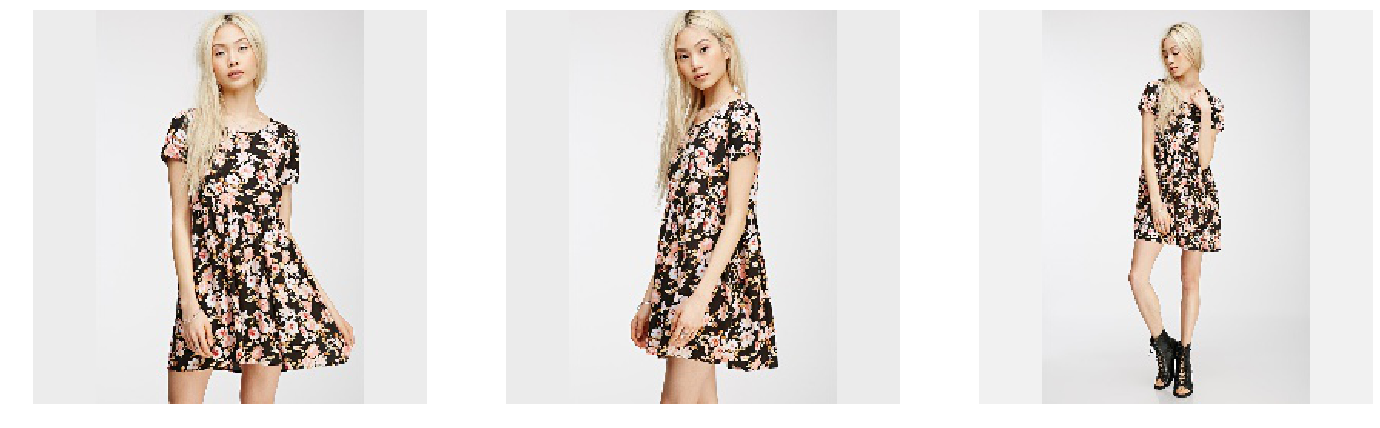

In [5]:
# show 3 of the images in the train_df
imgs = []
for k in train_df['image_name']:
    im = read_raw_image(k)
    imgs.append(im)
    if len(imgs) == 3:
        break
        
show_img(imgs, 3)

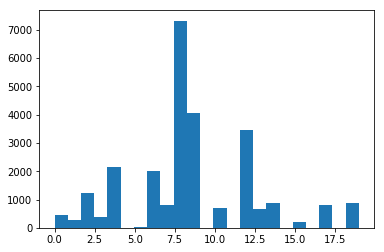

In [6]:
# show the category distribution
_ = plt.hist(train_df['category_label'], bins=num_category)

## DataAgu

In [7]:
def get_aug(rate=0.8):
    """data set augmentation tool.
    
    The official documents: https://github.com/aleju/imgaug
    
    Arguments
        rate: the rate to use data set augmentation tool. if 1, all of the images will use data 
            set augmentation tool, if 0, none of the images will use data set augmentation tool
    
    Return
        The configured data set augmentation tool
    """
    sometimes = lambda aug: iaa.Sometimes(rate, aug)
    seq = iaa.Sequential([
        sometimes([
            iaa.Fliplr(0.5),  # 水平翻转
            iaa.Flipud(0.5),  # 垂直翻转
            iaa.Crop(percent=(0, 0.15)),  # 随机剪切像素，并保证shape不变
            iaa.Sometimes(0.5, iaa.GaussianBlur(sigma=(0, 0.05))),  # 高斯模糊
            iaa.ContrastNormalization((0.75, 1.5)),  # 减弱或加强对比度
            iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255), per_channel=0.5),  # 高斯噪点
            iaa.Multiply((0.9, 1.1), per_channel=0.2),  # 随机变换色调
            iaa.Sometimes(0.6, iaa.Affine(
                scale={"x": (0.9, 1.1), "y": (0.8, 1.2)},
                translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)},
                rotate=(-15, 15),
                shear=(-8, 8)
            ))
        ]),
        iaa.Resize({'height': image_shape[0], 'width': image_shape[1]})
    ], random_order=True)
    return seq


def normal_image(img):
    """normalize an image by the Image Net's official preprocessing tool. 
    
    Arguments
        img: np.ndarray of pil.Image.Image
        
    Return
        the normalized image
    """
    if isinstance(img, Image.Image):
        img = np.array(img, K.floatx())
    img = preprocess_input(img)
    return img

In [8]:
print('身高{0}，家住{1}。'.format(1.8, '铜锣湾'))

身高1.8，家住铜锣湾。


## TrainSequence

训练集生成器，保证图片在训练过程中的供给

In [9]:
class TrainSequence(Sequence):
    """the train sequence that inherit from `Seqence` 
    
    Arguments
        data: a pd.DataFrame of train_df, val_df or test_df
        batch_size：the batch size to fit the model
    """
    def __init__(self, data: pd.DataFrame, batch_size=32):
        """耗时：1m 22s"""
        super().__init__()
        self.batch_size = batch_size
        
        self.data =data
        self.seq = get_aug(0.8)
        
        self.mlb = MultiLabelBinarizer()
#         self.mlb.classes_ = list(range(num_attr))  # 总共有463个属性
        self.mlb.fit([list(range(463))])
        self.on_epoch_end()
        
    def __getitem__(self, index):
        """耗时：265ms"""
        start = self.batch_size * index
        end = self.batch_size * (index + 1)-1
        batches = self.data.loc[start:end]
        seq = self.seq.to_deterministic()
        
        # 读取源数据
        xs_a, attrs, cates, lands_v, lands_local = [], [], [], [], []
        for i in range(len(batches)):
            # read image
            a = batches.iloc[i]
            x_a = normal_image(np.asarray(read_raw_image(a['image_name']).convert('RGB')))
            xs_a.append(x_a)
            
            # read attr, when a['attribute_labels'] has single label, it will be read as an int
            attr = [int(at) for at in str(a['attribute_labels']).split(' ') if at != '']
            attrs.append(attr)
            # read category
            cates.append(a['category_label'])
            # read landmark
            lands_v.extend([a['landmark_visibility_{0}'.format(ii)] for ii in range(1, 9)])
            lands_local.append(ia.KeypointsOnImage([
                ia.Keypoint(
                    x=a['landmark_location_x_{0}'.format(ii)],
                    y=a['landmark_location_y_{0}'.format(ii)]
                ) for ii in range(1, 9)
            ], shape=x_a.shape))
            
        # aug image
        xs_a = np.array(seq.augment_images(xs_a))
        # aug landmark   
        lands_v = to_categorical(lands_v, num_landmark_visibility)
        lands_local = seq.augment_keypoints(lands_local)
        res = []
        for local in lands_local:
            for keypoint in local.keypoints:
                res.append([keypoint.x, keypoint.y])
        lands_local = res
        try:
            lands_local = np.array(lands_local) / image_shape[:2]  # 缩放比例到0-1
        except ValueError as e:
            # 检查过所有数据输入都不能存在空值，但是仍然出现shape不一致，这里检查那个数据异常
#             raise ValueError(f"Error: {e}, \n image: {batches['image_name']}'， \n lands: {lands_local}")
            print("Value Error")
        lands = np.concatenate((lands_v, lands_local), axis=1)
        # from (None*8, 5) to (None, 8*5)
        lands = lands.reshape((len(batches), -1))
        
        # transform category
        cates = to_categorical(cates, num_category)
        # transsform attrs
        attrs = self.mlb.transform(attrs)

        return xs_a, [cates, lands, cates, attrs]
    
    def on_epoch_end(self):
        """耗时：1m 3.57s"""
        self.data = self.data.sample(frac=1.0).reset_index(drop=True)
    
    def __len__(self):
        return (len(self.data) + self.batch_size - 1) // self.batch_size

In [10]:
train = TrainSequence(data=train_df, batch_size=6)
xs_a, [cates, lands, cates, attrs] = train[0]

/root/miniconda3/envs/myconda/lib/python3.5/site-packages/imgaug/imgaug.py:184: DeprecationWarning: Function `ContrastNormalization()` is deprecated. Use `imgaug.contrast.LinearContrast` instead.
  warn_deprecated(msg, stacklevel=3)


```python
# the code to test the TrainSequence
train = TrainSequence(data=train_df, batch_size=6)
xs_a, [cates, lands, cates, attrs] = train[0]

lands_local = lands.reshape((-1, 5))[:, 3:].reshape((-1, 8, 2))
imgs = []
for i in range(len(xs_a)):
    keypoints = ia.KeypointsOnImage([ia.Keypoint(x=x[0], y=x[1]) for x in lands_local[i]], shape=xs_a[i].shape)
    imgs.append(keypoints.draw_on_image(xs_a[i], color=(255, 0, 0), size=7))
show_img(imgs, 3, rescale=False); lands
```

## ValSequence

In [11]:
class ValSequence(TrainSequence):
    """the val sequence that inherit from `TrainSeqence`
    
    Arguments
        data: a pd.DataFrame of train_df, val_df or test_df
        batch_size：the batch size to fit the model
    """
    def __init__(self, data: pd.DataFrame, batch_size=32):
        """耗时：1m 22s"""
        super().__init__(data=data, batch_size=batch_size)
        # make sure donot use data set augmentation by setting rate=0
        self.seq = get_aug(0)

In [12]:
train_df['category_label'].value_counts()

8     7319
9     4046
12    3464
4     2144
6     2010
2     1241
19     886
14     871
7      813
17     804
10     714
13     672
0      468
3      395
1      260
15     215
5       16
Name: category_label, dtype: int64

In [13]:
test = train_df[:100]
lands_v=[]
lands_v.extend([test['landmark_visibility_{0}'.format(ii)] for ii in range(1, 9)])
print(lands_v[0])
lands_v = to_categorical(lands_v, num_landmark_visibility)
print(lands_v[0])

0     1
1     1
2     0
3     0
4     1
     ..
95    0
96    0
97    0
98    0
99    0
Name: landmark_visibility_1, Length: 100, dtype: int64
[[0. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 

In [14]:
a = [1,0.5,0]
b = to_categorical(a,3)
print(b)

[[0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]]


## Model

In [15]:
def category_classweight():
    """calculate the category's class weight
    
    Return
        an 1D np.ndarray which index is equal to the category's index
    """
    class_dict = train_df['category_label'].value_counts().to_dict()
    num_max = max(class_dict.values())
    class_weight = []
    for i in range(num_category):
        if i not in class_dict:
            class_weight.append(0.)
        else:
            class_weight.append(730 / class_dict[i])
    class_weight = np.array(class_weight)
    return class_weight


def attribute_classweight():
    """calculate the attribute's class weight
    
    Return
        p_weight: the positive weight of the train_df
        n_weight: the negative weight of the train_df
    """
    p_weight = 0
    for i in range(len(train_df)):
        attrs = str(train_df.loc[i]['attribute_labels'])
        p_weight += len(attrs.split(' '))
    p_weight = p_weight / (len(train_df) * num_attr)
    n_weight = 1 - p_weight
    return p_weight, n_weight


category_weight = category_classweight()
attribute_weight = attribute_classweight(); attribute_weight, category_weight            

((0.04142968129714935, 0.9585703187028507),
 array([ 1.55982906,  2.80769231,  0.58823529,  1.84810127,  0.34048507,
        45.625     ,  0.36318408,  0.89790898,  0.0997404 ,  0.18042511,
         1.02240896,  0.        ,  0.21073903,  1.08630952,  0.83811711,
         3.39534884,  0.        ,  0.9079602 ,  0.        ,  0.82392777,
         0.        ,  0.        ,  0.        ]))

In [16]:
def category_loss(y_true, y_pred, gamma=0.):
    """the category loss using focal loss.
    
    The reference paper of focal loss is Focal Loss for Dense Object Detection
    
    Arguments
        y_true: the learning target, shape=(None, 23)
        y_pred: the predicted value, shape=(None, 23)
        gamma: if 0, focal loss is equal to the category crossentropy loss.
    
    Return
        the loss of shape=(None, 1)
    """
    loss = -y_true * K.log(y_pred + K.epsilon()) * category_weight
    loss = K.sum(loss, axis=-1)
    return loss


def attribute_loss(y_true, y_pred, gamma=0.):
    """the attribute loss using focal loss.
    
    The reference paper of focal loss is Focal Loss for Dense Object Detection
    
    Arguments
        y_true: the learning target, shape=(None, 463)
        y_pred: the predicted value, shape=(None, 463)
        gamma: if 0, focal loss is equal to the category crossentropy loss.
        
    Return
        the loss of shape=(None, 1)
    """
    y_ = y_true * y_pred + (1.0 - y_true) * (1.0 - y_pred) + K.epsilon()
    loss = -K.log(y_)

    weight = y_true * attribute_weight[0] + (1.0 - y_true) * attribute_weight[1]
    loss *= weight

    loss = K.sum(loss, axis=-1)
    return loss


def lands_loss(y_true, y_pred):
    """the landmarks loss that consists of two parts, the category crossentropy of landmarks' visibility
    and the L2 loss of landmarks' location
    
    Arguments
        y_true: the learning target, shape=(None, 40). And each landmark consists of the visibility's status
            of 3 elements and the location (x/w, y/h) of 2 elements. And each image has 8 landmarks.
        y_pred: the predicted value, shape=(None, 40).
        
    Return
        the loss of shape=(None, 1)
    """
    y_true = K.reshape(y_true, (-1, 5))
    y_pred = K.reshape(y_pred, (-1, 5))
    
    lands_true = y_true[:, 3:]
    lands_pred = y_pred[:, 3:]
    lands_gate = y_true[:, 0, None]    # only the visiable landmarks will be calculated
    lands = K.sum((K.sigmoid(lands_pred) - lands_true) ** 2 * lands_gate, axis=-1)
    
    lands_v_true = y_true[:, :3]
    lands_v_pred = y_pred[:, :3]
    visibility = -lands_v_true * K.log(K.softmax(lands_v_pred) + K.epsilon())
    visibility = K.sum(visibility, axis=-1)
    
    loss = lands + visibility
    loss = K.sum(K.reshape(loss, (-1, 8)), axis=-1)
    return loss


def triplet_loss(y_true, y_pred):
    """the triplet loss.
    
    The reference paper of focal loss is In Defense of the Triplet Loss for Person Re-Identification.
    
    Arguments
        y_true: the learning target, shape=(None, 1). In fact, the triplet loss dosen't need any target,
            but the keras framework need.
        y_pred: the predicted value, shape=(None, length of the output tensor)
    
    Return
        the loss of shape=(None, 1)
    """
    
    margin = 0.3
    loss = K.sum(y_pred, axis=-1, keepdims=True)
    # donot use K.max, it calculates maximum value in a tensor.
    loss = K.maximum(0., margin + loss + 0. * y_true)
    return loss

def top1(y_true, y_pred, k=1):
    """top1 categorical accuracy
    
    Arguments
        y_true: the learning target, shape=(None, 23)
        y_pred: the predicted value, shape=(None, 23)
        
    Returns
        the top1-acc of shape=(None, 1)
    """
    return K.cast(K.in_top_k(y_pred, K.argmax(y_true, axis=-1), k), K.floatx())


def top2(y_true, y_pred, k=2):
    """top2 categorical accuracy
    
    Arguments
        y_true: the learning target, shape=(None, 23)
        y_pred: the predicted value, shape=(None, 23)
        
    Returns
        the top2-acc of shape=(None, 1)
    """
    return K.cast(K.in_top_k(y_pred, K.argmax(y_true, axis=-1), k), K.floatx())


def top3(y_true, y_pred, k=3):
    """top3 categorical accuracy
    
    Arguments
        y_true: the learning target, shape=(None, 23)
        y_pred: the predicted value, shape=(None, 23)
        
    Returns
        the top3-acc of shape=(None, 1)
    """
    return K.cast(K.in_top_k(y_pred, K.argmax(y_true, axis=-1), k), K.floatx())


def top5(y_true, y_pred, k=5):
    """top5 categorical accuracy
    
    Arguments
        y_true: the learning target, shape=(None, 23)
        y_pred: the predicted value, shape=(None, 23)
        
    Returns
        the top5-acc of shape=(None, 1)
    """
    return K.cast(K.in_top_k(y_pred, K.argmax(y_true, axis=-1), k), K.floatx())

### Roi pooling

In [17]:
class RoiPooling(Layer):
    """Landmark ROI pooling layer for 2D inputs.
    
    See Spatial Pyramid Pooling in Deep Convolutional Networks for Visual Recognition
    
    Arguments
        pool_size: int. Size of pooling region to use. pool_size = 7 will result in a 7x7 region.
        num_rois: number of regions of interest to be used
        window_size: the slide window size
        
    Input shape
        list of one 4D tensor and one 2D tensor  [X_img,X_roi] with shape:
        X_img: (batches, channels, rows, cols) if dim_ordering='th' or 4D tensor with shape:
            (batch, rows, cols, channels) if dim_ordering='tf'.
        X_roi: (batches, num_rois * 5) list of rois, with ordering (x_left_top, y_left_top) in the
            first two elements where axis=-1.
            
    Output shape
        4D tensor with shape:
            (batches, pool_size, pool_size, channels * num_rois) if dim_ordering='tf'
            (batch, channels * num_rois, pool_size, pool_size) if dim_ordering='th'
    """
    def __init__(self, pool_size=2, num_rois=8, window_size=4, **kwargs):
        self.dim_ordering = K.image_dim_ordering()
        assert self.dim_ordering in {'tf', 'th'}, 'dim_ordering must be in {tf, th}'
        self.window_size = window_size
        self.pool_size = pool_size
        self.num_rois = num_rois
        self.data_format = 'channels_last' if self.dim_ordering == 'tf' else 'channels_first'
        super().__init__(**kwargs)

    def build(self, input_shape):
        if self.dim_ordering == 'th':
            self.nb_channels = input_shape[0][1]
        elif self.dim_ordering == 'tf':
            self.nb_channels = input_shape[0][3]

    def compute_output_shape(self, input_shape):
        if self.dim_ordering == 'th':
            return None, self.num_rois * self.nb_channels, self.pool_size, self.pool_size
        else:
            return None, self.pool_size, self.pool_size, self.nb_channels * self.num_rois

    def call(self, x, mask=None): 
        assert (len(x) == 2)
        # 输入特征，坐标信息
        img, rois = x[0], x[1]
        
        # convert img
        if self.dim_ordering == 'th':
            img = K.permute_dimensions(img, (0, 2, 3, 1))
        else:
            img = K.permute_dimensions(img, (0, 1, 2, 3))
        
        # convert boxes
        shape = K.int_shape(img)
        
        rois = K.reshape(rois, (-1, 5))[:, 3:]
        x1 = rois[..., 0]
        y1 = rois[..., 1]
        x2 = rois[..., 0] + K.cast(self.window_size / shape[2], K.floatx())
        y2 = rois[..., 1] + K.cast(self.window_size / shape[1], K.floatx())
        
        x1 = K.expand_dims(x1, axis=-1)
        y1 = K.expand_dims(y1, axis=-1)
        x2 = K.expand_dims(x2, axis=-1)
        y2 = K.expand_dims(y2, axis=-1)

        boxes = K.concatenate([y1, x1, y2, x2], axis=-1)
        
        # convert img
        img = K.concatenate([img] * self.num_rois, axis=1)
        img = K.reshape(img, (-1, ) + shape[1:])
        
        # crop and resize image
        # input: img(None*8, H, W, C), boxes(None*8, 4)
        # return: tensor(None, slice_height, slice_width, C*num_boxes)
        box_ind = K.zeros_like(boxes, 'int32')
        box_ind = box_ind[..., 0]
        box_ind = K.reshape(box_ind, (-1, ))
        
        slices = tf.image.crop_and_resize(img, boxes, box_ind, (self.pool_size, self.pool_size))
        slices = K.reshape(slices, (-1, self.pool_size, self.pool_size, self.num_rois * shape[-1]))

        if self.dim_ordering == 'th':
            slices = K.permute_dimensions(slices, (0, 3, 1, 2))
        else:
            slices = K.permute_dimensions(slices, (0, 1, 2, 3))

        return slices

### build model

In [18]:
def build_model():
    """build the Fashion Net model
    
    The reference paper of focal loss is DeepFashion: Powering Robust Clothes Recognition and 
    Retrieval with Rich Annotations.
    
    Using batchnormalization to avoid that the output of the nn is 0.
    
    Arguments
        lr: the learning rate
    
    Return
        model_stage1: the first stage model for train
        model_stage2: the second stage model for train
        model_blue: the model for the prediction of categroy, landmarks visibility and landmarks location
    """
    kwargs = {'kernel_initializer': 'he_normal', 'padding': 'same'}
    fkwargs = {'kernel_initializer': 'he_normal'}
    
    # base model
    inp_a = layers.Input(shape=image_shape, name='inp_a')
    inp_p = layers.Input(shape=image_shape, name='inp_p')
    inp_n = layers.Input(shape=image_shape, name='inp_n')
    
    model = VGG16(input_tensor=inp_a, weights='/Fashion/FashionNet/src/weights/vgg16_weights_tf_dim_ordering_tf_kernels.h5')
    # if using model.trainable = False, the block5 will be untrainable too
    for layer in model.layers:
        if layer.name == 'block4_pool':
            break
        else:
            layer.trainable = False
    node = model.get_layer(name='block4_conv3').output
    
    # blue
    blue = layers.MaxPool2D((2, 2), strides=(2, 2), name='blue_pool1')(node)
    blue = layers.Conv2D(512, (3, 3), activation='relu', name='blue_conv1', **kwargs)(blue)
    blue = layers.Conv2D(512, (3, 3), activation='relu', name='blue_conv2', **kwargs)(blue)
    blue = layers.Conv2D(512, (3, 3), activation='relu', name='blue_conv3', **kwargs)(blue)
    blue = layers.MaxPool2D((2, 2), strides=(2, 2), name='blue_pool')(blue)   
    
    blue = layers.Flatten(name='blue_flatten')(blue)
    
    blue = layers.Dense(4096, name='blue_fc1', **fkwargs)(blue)
    blue = layers.BatchNormalization(name='blue_normal1')(blue)
    blue = layers.Activation('relu', name='blue_fc1_activation')(blue)
    blue = layers.Dense(4096, name='blue_fc2', **fkwargs)(blue)
    blue = layers.BatchNormalization(name='blue_normal2')(blue)
    blue = layers.Activation('relu', name='blue_fc2_activation')(blue)
    ## land marks and category loss
    blue_cates = layers.Dense(
        num_category,
        kernel_initializer='he_normal',
        activation='softmax',
        name='blue_cates'
    )(blue)
    blue_lands = layers.Dense(8 * (3 + 2), kernel_initializer='he_normal', name='blue_lands')(blue)
    model_blue = Model(inp_a, [blue_cates, blue_lands], name='model_blue')
    
    # red
    red = layers.MaxPool2D((2, 2), strides=(2, 2), name='red_pool1')(node)
    red = layers.Conv2D(512, (3, 3), activation='relu', name='red_conv1', **kwargs)(red)
    red = layers.Conv2D(512, (3, 3), activation='relu', name='red_conv2', **kwargs)(red)
    red = layers.Conv2D(512, (3, 3), activation='relu', name='red_conv3', **kwargs)(red)
    red = layers.MaxPooling2D((2, 2), strides=(2, 2), name='red_pool')(red)
    red = layers.Flatten(name='red_flatten')(red)
    red = layers.Dense(4096, name='red_fc1', **fkwargs)(red)
    
    # green
    green = RoiPooling(pool_size=2, num_rois=8, window_size=4, name='green_roi')([node, blue_lands])
    green = layers.Flatten(name='green_flatten')(green)
    green = layers.Dense(1024, name='green_fc1', **fkwargs)(green)
    
    # concate the red and green
    red_green = layers.concatenate([red, green], name='concate')
    red_green = layers.BatchNormalization(name='concate_normal')(red_green)
    red_green = layers.Activation('relu', name='concate_activation')(red_green)
    ## concate category loss
    red_green_cates = layers.Dense(
        num_category,
        kernel_initializer='he_normal',
        activation='softmax',
        name='concate_category'
    )(red_green)
    ## attribute loss
    red_green_attrs = layers.Dense(
        num_attr,
        kernel_initializer='he_normal',
        activation='sigmoid',
        name='attribute'
    )(red_green)
      
    model_source = Model(inp_a, [blue_cates, blue_lands, red_green_cates, red_green_attrs])
    
    # turning weights
    for layer in model.layers:
        name = layer.name
        if 'block5' in name:
            blue_name = "blue_{0}".format(name.split('_')[1])
            model_source.get_layer(blue_name).set_weights(layer.get_weights())
            red_name = "red_{0}".format(name.split('_')[1])
            model_source.get_layer(red_name).set_weights(layer.get_weights())

    return model_source, model_blue
    

def change_stage(model, lr=3e-4, stage=1):
    """change the model's training stage
    
    Arguments
        model: the model object
        lr: learning rate
        stage: if 1, blue model will be trainable, if 2, blue model will be untrainable
    """
    opt = Adam(lr)
    # stage1: train the blue node
    if stage == 1:
        for layer in model.layers:
            if 'blue' in layer.name:
                layer.trainable = True 
        model.compile(
            opt,
            loss={
                'blue_cates': category_loss,
                'blue_lands': lands_loss,
                'concate_category': category_loss,
                'attribute': attribute_loss,
            },
            loss_weights={
                'blue_cates': 1.,
                'blue_lands': 1.,
                'concate_category': 0.1,
                'attribute': 0.1,
            },
            metrics={
                'blue_cates': [top1, top2, top3, top5]
            }
        )
    # stage2: train the red and green node
    elif stage == 2:
        for layer in model.layers:
            if 'blue' in layer.name:
                layer.trainable = False
                
        model.compile(
            opt,
            loss={
                'blue_cates': category_loss,
                'blue_lands': lands_loss,
                'concate_category': category_loss,
                'attribute': attribute_loss
            },
            loss_weights={
                'blue_cates': 0.,
                'blue_lands': 0.,
                'concate_category': 1.,
                'attribute': 1.
            },
            metrics={
                'concate_category': [top1, top2, top3, top5]
            }
        )
    return model
    
model_source, model_blue = build_model()
model = change_stage(model_source); model.summary()

Instructions for updating:
Colocations handled automatically by placer.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inp_a (InputLayer)              (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 224, 224, 64) 1792        inp_a[0][0]                      
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 224, 224, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 112, 112, 64) 0           block1_conv2[0][0]               
_____________________________________

In [19]:
class LRFinder(object):
    """Plots the change of the loss function of a Keras model when the learning rate is exponentially
    increasing. See for details: 
    https://towardsdatascience.com/estimating-optimal-learning-rate-for-a-deep-neural-network-ce32f2556ce0
    """
    def __init__(self, model):
        self.model = model
        self.losses = []
        self.lrs = []
        self.best_loss = 1e9

    def on_batch_end(self, batch, logs):
        # Log the learning rate
        lr = K.get_value(self.model.optimizer.lr)
        self.lrs.append(lr)

        # Log the loss
        loss = logs['loss']
        self.losses.append(loss)

        # Check whether the loss got too large or NaN
        if math.isnan(loss) or loss > self.best_loss * 4:
            self.model.stop_training = True
            return

        if loss < self.best_loss:
            self.best_loss = loss

        # Increase the learning rate for the next batch
        lr *= self.lr_mult
        K.set_value(self.model.optimizer.lr, lr)

    def find(self, data_gen, start_lr, end_lr, epochs=1, class_weight=None):
        num_batches = epochs * len(data_gen)
        self.lr_mult = (float(end_lr) / float(start_lr)) ** (float(1) / float(num_batches))

        # Save weights into a file
        self.model.save_weights('tmp.h5')

        # Remember the original learning rate
        original_lr = K.get_value(self.model.optimizer.lr)

        # Set the initial learning rate
        K.set_value(self.model.optimizer.lr, start_lr)

        callback = LambdaCallback(on_batch_end=lambda batch, logs: self.on_batch_end(batch, logs))

        self.model.fit_generator(data_gen, epochs=epochs, callbacks=[callback], class_weight=class_weight)

        # Restore the weights to the state before model fitting
        self.model.load_weights('tmp.h5')

        # Restore the original learning rate
        K.set_value(self.model.optimizer.lr, original_lr)

    def plot_loss(self, n_skip_beginning=10, n_skip_end=5):
        """
        Plots the loss.
        Parameters:
            n_skip_beginning - number of batches to skip on the left.
            n_skip_end - number of batches to skip on the right.
        """
        plt.ylabel("loss")
        plt.xlabel("learning rate (log scale)")
        plt.plot(self.lrs[n_skip_beginning:-n_skip_end], self.losses[n_skip_beginning:-n_skip_end])
        plt.xscale('log')

    def plot_loss_change(self, sma=1, n_skip_beginning=10, n_skip_end=5, y_lim=(-0.01, 0.01)):
        """
        Plots rate of change of the loss function.
        Parameters:
            sma - number of batches for simple moving average to smooth out the curve.
            n_skip_beginning - number of batches to skip on the left.
            n_skip_end - number of batches to skip on the right.
            y_lim - limits for the y axis.
        """
        assert sma >= 1
        derivatives = [0] * sma
        for i in range(sma, len(self.lrs)):
            derivative = (self.losses[i] - self.losses[i - sma]) / sma
            derivatives.append(derivative)

        plt.ylabel("rate of loss change")
        plt.xlabel("learning rate (log scale)")
        plt.plot(self.lrs[n_skip_beginning:-n_skip_end], derivatives[n_skip_beginning:-n_skip_end])
        plt.xscale('log')
        plt.ylim(y_lim)
    
    def plot_loss_smoothing(self, smoothing=0.6, n_skip_beginning=10, n_skip_end=5):
        """plot smoothing as like tensorboard
        """
        losses, lrs = self.losses[n_skip_beginning:-n_skip_end], self.lrs[n_skip_beginning:-n_skip_end]
        last = losses[0]
        smoothes = []
        for point in losses:
            smooth = last * smoothing + (1-smoothing) * point
            smoothes.append(smooth)
            last = point
        
        plt.ylabel("rate of loss smoothing")
        plt.xlabel("learning rate (log scale)")
        plt.plot(lrs, smoothes)
        plt.xscale('log')

## Train

In [20]:
def set_lr(model, lr):
    """config the model's learning rate"""
    K.set_value(model.optimizer.lr, float(lr))
    
    
def get_lr(model):
    """get the model's learning rate"""
    return K.get_value(model.optimizer.lr)


def save_model(model):
    """save the model of current step into the MODEL_PATH"""
#     model.save(f'{MODEL_PATH}epoch{steps}.h5')
    model.save('{0}epoch{1}.h5'.format(MODEL_PATH,steps))
    
    
def load_model(model, temp_step):
    """load model from what the function save_model saved
    
    Arguments
        model: the model have been built
        temp_step: which step of the model you want to load
    
    Return
        the loaded model
    """
    global steps
    steps = temp_step
    
    model_file = '{0}epoch{1}.h5'.format(MODEL_PATH,steps) #f'{MODEL_PATH}epoch{steps}.h5'
    tmp = keras.models.load_model(model_file, compile=False)
    model.set_weights(tmp.get_weights())
    return model
    

def load_modelfile(model, modelfile):
    """load the model from model path
    
    Arguments
        model: the model have been built
        modelfile: the model file path, such as '../data/output/models/fashionnet/epoch.04-0.22-0.333.h5' or
            'epoch.04-0.22-0.333.h5'
    
    Return
        the loaded model
    """
    global steps
    steps = int(modelfile.split('-')[0].split('.')[-1])
    
    model_file = '{0}{1}'.format(MODEL_PATH,modelfile)#f'{MODEL_PATH}{modelfile}'
#     tmp = keras.models.load_model(model_file, compile=False, custom_objects={
#         'RoiPooling': RoiPooling
#     })
#     model.set_weights(tmp.get_weights())
    model.load_weights(model_file, by_name=True)
    return model
    
    
def callbacks():
    """get the configured keras train callbacks"""
    ckpt_file = MODEL_PATH + 'ckpt_model.{epoch:02d}-{val_loss:.4f}-{val_blue_cates_loss:.4f}.h5'
    checkpoint = ModelCheckpoint(ckpt_file, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
    
#     csv_log_file = f'{LOGGER_PATH}{model_dict[no_model]}.csv'
    csv_log_file='{0}{1}.csv'.format(LOGGER_PATH,model_dict[no_model])
    csv_log = CSVLogger(csv_log_file)
    
#     tensorboard = TensorBoard(f'{LOGGER_PATH}')
    tensorboard = TensorBoard(LOGGER_PATH)
    
    return [checkpoint, csv_log, tensorboard]


def make_steps(step):
    """training some epoches
    
    Arguments
        step: how many epoches the model will be trained 
    """
    global steps, histories

    # Train the model for 'step' epochs
    history = model.fit_generator(
        TrainSequence(train_df, batch_size=64),
        validation_data=ValSequence(val_df, batch_size=64),
        callbacks=callbacks(),
        initial_epoch=steps, epochs=steps + step, max_queue_size=12, workers=8, verbose=1).history
    steps += step

    # Collect history data
    history['epochs'] = steps
    history['lr'] = get_lr(model)
    print(history['epochs'], history['lr'])
    histories.append(history)
    
    
def find_lr(model, start_lr=3e-5, end_lr=1):
    """plot the loss-lr curve to find an appropriate model"""
    lr_finder = LRFinder(model)
    lr_finder.find(
        TrainSequence(train_df, batch_size=8),
        start_lr=start_lr, end_lr=end_lr
    )
    lr_finder.plot_loss()
    return lr_finder

### StartTrain

In [21]:
histories = []
steps = 0

### stage1

找到上阶段最佳模型，使用第1阶段模型继续训练。如果一开始训练，准确率就高达99%，那么多半是初始化异常，重新启动初始化就好

In [22]:
# model = change_stage(model, lr=1e-4, stage=1)
# make_steps(10)

/root/miniconda3/envs/myconda/lib/python3.5/site-packages/imgaug/imgaug.py:184: DeprecationWarning: Function `ContrastNormalization()` is deprecated. Use `imgaug.contrast.LinearContrast` instead.
  warn_deprecated(msg, stacklevel=3)


Instructions for updating:
Use tf.cast instead.
Epoch 1/10
412/412 [==============================] - 307s 745ms/step - loss: 8.2793 - blue_cates_loss: 1.0679 - blue_lands_loss: 5.8347 - concate_category_loss: 1.0968 - attribute_loss: 12.6695 - blue_cates_top1: 0.2560 - blue_cates_top2: 0.4260 - blue_cates_top3: 0.5440 - blue_cates_top5: 0.7098 - val_loss: 5.7767 - val_blue_cates_loss: 1.1150 - val_blue_lands_loss: 4.0079 - val_concate_category_loss: 1.6397 - val_attribute_loss: 4.8994 - val_blue_cates_top1: 0.3448 - val_blue_cates_top2: 0.5342 - val_blue_cates_top3: 0.6687 - val_blue_cates_top5: 0.8371

Epoch 00001: val_loss improved from inf to 5.77673, saving model to ../data/output/models/fashionnet/ckpt_model.01-5.7767-1.1150.h5
Epoch 2/10
412/412 [==============================] - 290s 705ms/step - loss: 5.9107 - blue_cates_loss: 0.7835 - blue_lands_loss: 4.5689 - concate_category_loss: 0.8393 - attribute_loss: 4.7436 - blue_cates_top1: 0.3848 - blue_cates_top2: 0.5982 - blue_cat

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



### stage2

找到上阶段最佳模型，使用第2阶段模型继续训练

In [23]:
model = load_modelfile(model, 'ckpt_model.06-4.3133-0.8884.h5')

In [24]:
model = change_stage(model, lr=1e-4, stage=2)
make_steps(2)

/root/miniconda3/envs/myconda/lib/python3.5/site-packages/imgaug/imgaug.py:184: DeprecationWarning: Function `ContrastNormalization()` is deprecated. Use `imgaug.contrast.LinearContrast` instead.
  warn_deprecated(msg, stacklevel=3)


Instructions for updating:
Use tf.cast instead.
Epoch 7/8
412/412 [==============================] - 303s 736ms/step - loss: 4.7785 - blue_cates_loss: 0.4547 - blue_lands_loss: 3.4059 - concate_category_loss: 0.4696 - attribute_loss: 4.3089 - concate_category_top1: 0.5927 - concate_category_top2: 0.7936 - concate_category_top3: 0.8860 - concate_category_top5: 0.9602 - val_loss: 5.5413 - val_blue_cates_loss: 0.8884 - val_blue_lands_loss: 2.8887 - val_concate_category_loss: 0.9968 - val_attribute_loss: 4.5445 - val_concate_category_top1: 0.5531 - val_concate_category_top2: 0.7628 - val_concate_category_top3: 0.8606 - val_concate_category_top5: 0.9412

Epoch 00007: val_loss improved from inf to 5.54135, saving model to ../data/output/models/fashionnet/ckpt_model.07-5.5413-0.8884.h5
Epoch 8/8
412/412 [==============================] - 295s 715ms/step - loss: 4.7381 - blue_cates_loss: 0.4551 - blue_lands_loss: 3.3897 - concate_category_loss: 0.4718 - attribute_loss: 4.2663 - concate_categor

In [33]:
train = TrainSequence(data=test_df, batch_size=6)
print(train[0][0].shape)
predictions = model.predict(train[0][0]) #显示每一个测试集各个类别的概率，这个值的shape为（10000,10）
# from numpy import random
# randArray = random.random(size=(1,224,224,3))
# predictions = model.predict(randArray)
# # print(predictions[0].shape,predictions[1].shape,predictions[2].shape,predictions[3].shape)
# print(np.argmax(predictions[0]),np.argmax(predictions[2]))
print(predictions)
print(predictions[0].shape)

/root/miniconda3/envs/myconda/lib/python3.5/site-packages/imgaug/imgaug.py:184: DeprecationWarning: Function `ContrastNormalization()` is deprecated. Use `imgaug.contrast.LinearContrast` instead.
  warn_deprecated(msg, stacklevel=3)


(6, 224, 224, 3)
[array([[4.13508154e-03, 6.21859290e-05, 4.39713746e-02, 7.11473986e-04,
        2.05410947e-03, 8.96722486e-05, 2.93217693e-03, 1.81574794e-03,
        5.40666357e-02, 1.76888388e-02, 2.66310712e-03, 3.04147688e-05,
        6.69742107e-01, 1.51822378e-03, 4.91467956e-03, 1.71523786e-03,
        2.73951646e-05, 8.10191631e-02, 1.50329015e-05, 1.10699311e-01,
        1.56304486e-05, 8.23649898e-05, 3.01404016e-05],
       [1.72533549e-03, 1.39067729e-03, 2.11602286e-03, 1.29168062e-02,
        3.45174712e-03, 2.37669214e-03, 6.45565838e-02, 9.39591378e-02,
        3.12178284e-01, 1.23716153e-01, 1.21864695e-02, 1.55152575e-05,
        3.00088692e-02, 2.74130374e-01, 3.54268216e-02, 2.79684574e-03,
        6.71625230e-06, 2.52299253e-02, 8.78708761e-06, 1.72012148e-03,
        4.57368078e-05, 1.59265419e-05, 2.04961234e-05],
       [1.76989211e-04, 1.26876121e-05, 8.45643692e-03, 1.29300077e-03,
        1.04021805e-03, 7.52109481e-05, 1.58539356e-03, 1.43873534e-04,
    

### stage3

进一步降低lr，并重新训练第一阶段模型

In [30]:
model ‘= change_stage(model, lr=3e-5, stage=1)
make_steps(2)

/root/miniconda3/envs/myconda/lib/python3.5/site-packages/imgaug/imgaug.py:184: DeprecationWarning: Function `ContrastNormalization()` is deprecated. Use `imgaug.contrast.LinearContrast` instead.
  warn_deprecated(msg, stacklevel=3)


Epoch 4/5


ResourceExhaustedError: OOM when allocating tensor with shape[64,224,224,64] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node block1_conv1/convolution}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

	 [[{{node metrics_3/top1/Mean}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.


### stage4

In [20]:
# model = load_modelfile(model, 'ckpt_model.14-4.1022-0.8233.h5')

In [57]:
# model = load_modelfile(model, 'ckpt_model.03-5.4401-0.8805.h5')
# # img = Image.open('../data/input/Img/img/MEN/Denim/id_00000080/01_1_front.jpg')
# # num_img = np.asarray(img)
# # print(num_img.shape)
# from numpy import random
# randArray = random.random(size=(1,224,224,3))
# predictions = model.predict(randArray)
# # print(predictions[0].shape,predictions[1].shape,predictions[2].shape,predictions[3].shape)
# print(np.argmax(predictions[0]),np.argmax(predictions[2]))

15 8


(1, 23) (1, 40) (1, 23) (1, 463)
15 8


### stage5

重复以上2个步骤，直到模型最终拟合